In [18]:
import os
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
import common_evaluation

# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laraw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\laraw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Step 1: Basic preprocessing

In [19]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

## Step 2: Compute average word embedding for a document

In [20]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Step 3: Compute cosine similarity between two vectors

In [21]:
def compute_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

## Step 4: Convert similarity score to class label (0 to 3)

In [22]:
def classify_similarity(sim):
    if sim >= 0.90:
        return 1
    elif sim >= 0.75:
        return 2
    elif sim >= 0.50:
        return 3
    else:
        return 4

## Main comparison function

In [23]:
def compare_articles(text_a, text_b, model):
    tokens_a = simple_preprocess(text_a)
    tokens_b = simple_preprocess(text_b)

    vec_a = average_embedding(tokens_a, model)
    vec_b = average_embedding(tokens_b, model)

    sim = compute_similarity(vec_a, vec_b)
    label = classify_similarity(sim)

    return sim, label

## Classification Prediction

In [24]:
def predict_classification_with_titles(X, model):
    predictions = []

    for _, row in X.iterrows():
        title_a = row['title1']
        title_b = row['title2']

        sim, label = compare_articles(title_a, title_b, model)
        predictions.append(label)

    return predictions

def predict_classification_with_text(X, model):
    predictions = []

    for _, row in X.iterrows():
        text_a = row['text1']
        text_b = row['text2']

        sim, label = compare_articles(text_a, text_b, model)
        predictions.append(label)

    return predictions

def predict_classification(X, model):
    predictions = []

    for _, row in X.iterrows():
        text_a = str(row['title1']) + " " + str(row['text1'])
        text_b = str(row['title2']) + " " + str(row['text2'])

        sim, label = compare_articles(text_a, text_b, model)
        predictions.append(label)

    return predictions

## Regression Prediction

In [25]:
def predict_regression_with_titles(X, model):
    predictions = []

    for _, row in X.iterrows():
        title_a = row['title1']
        title_b = row['title2']

        sim, label = compare_articles(title_a, title_b, model)
        # Rescale from [0, 1] → [4, 1]
        sim_rescaled = 1 + 3 * (1 - sim)
        sim_rescaled = np.clip(sim_rescaled, 1, 4)
        predictions.append(sim_rescaled)

    return predictions

def predict_regression(X, model):
    predictions = []

    for _, row in X.iterrows():
        text_a = str(row['title1']) + " " + str(row['text1'])
        text_b = str(row['title2']) + " " + str(row['text2'])

        sim, label = compare_articles(text_a, text_b, model)
        # Rescale from [0, 1] → [4, 1]
        sim_rescaled = 1 + 3 * (1 - sim)
        sim_rescaled = np.clip(sim_rescaled, 1, 4)
        predictions.append(sim_rescaled)

    return predictions

## Main Evaluation Function

In [26]:
def evaluate(data, model):
    # Predict as Classification
    print("\nClassification using only titles...")
    data['pred_class_title_only'] = predict_classification_with_titles(data, model)
    acc = accuracy_score(data['overall_classification'], data['pred_class_title_only'])
    prec = precision_score(data['overall_classification'], data['pred_class_title_only'], average='weighted')
    rec = recall_score(data['overall_classification'], data['pred_class_title_only'], average='weighted')
    f1 = f1_score(data['overall_classification'], data['pred_class_title_only'], average='weighted')
    print(f"Accuracy Classification (titles only): {acc:.3f}")
    print(f"Precision Classification (titles only): {prec:.3f}")
    print(f"Recall Classification (titles only): {rec:.3f}")
    print(f"F1 Score Classification (titles only): {f1:.3f}")

    print("\nClassification using only text...")
    data['pred_class_text_only'] = predict_classification_with_text(data, model)
    acc = accuracy_score(data['overall_classification'], data['pred_class_text_only'])
    prec = precision_score(data['overall_classification'], data['pred_class_text_only'], average='weighted')
    rec = recall_score(data['overall_classification'], data['pred_class_text_only'], average='weighted')
    f1 = f1_score(data['overall_classification'], data['pred_class_text_only'], average='weighted')
    print(f"Accuracy Classification (text only): {acc:.3f}")
    print(f"Precision Classification (text only): {prec:.3f}")
    print(f"Recall Classification (text only): {rec:.3f}")
    print(f"F1 Score Classification (text only): {f1:.3f}")

    # Predict as Regression
    print("\nRegression using only titles...")
    data['pred_reg_title_only'] = predict_regression_with_titles(data, model)
    # Scale from [0, 1] to [1, 4] range
    data['pred_reg_title_only'] = data['pred_reg_title_only'] * 3 + 1

    mse = mean_squared_error(data['overall'], data['pred_reg_title_only'])
    mae = mean_absolute_error(data['overall'], data['pred_reg_title_only'])
    r2 = r2_score(data['overall'], data['pred_reg_title_only'])

    print("Scores Regression (titles only):")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² : {r2:.4f}")

    print()
    display(data)

## Evaluation with Word2Vec

In [27]:
# Load CSV with all pairs
print("Loading CSV...")
df = pd.read_csv("data/full_dataset.csv")

# Filter for English-only pairs
# df = df[(df["lang1"] == "en") & (df["lang2"] == "en")].reset_index(drop=True)

# Load pre-trained Word2Vec model (Google News vectors)
print("Loading Word2Vec model ...")
model = KeyedVectors.load_word2vec_format("pretrained_models/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

evaluate(df, model)

Loading CSV...
Loading Word2Vec model ...

Classification using only titles...
Accuracy Classification (titles only): 0.412
Precision Classification (titles only): 0.414
Recall Classification (titles only): 0.412
F1 Score Classification (titles only): 0.400

Classification using only text...
Accuracy Classification (text only): 0.210
Precision Classification (text only): 0.293
Recall Classification (text only): 0.210
F1 Score Classification (text only): 0.136

Regression using only titles...
Scores Regression (titles only):
MSE: 34.6471
MAE: 5.4557
R² : -26.2641



,pair_id,title1,text1,lang1,title2,text2,lang2,overall,overall_classification,geography,entities,time,narrative,style,tone,pred_class_title_only,pred_class_text_only,pred_reg_title_only
0,1484084337_1484110209,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",en,Haiti’s leader marks independence day amid sec...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",en,4.000000,4,4.0,4.000000,1.000000,4.000000,1.666667,2.000000,4,2,10.173656
1,1484396422_1483924666,Guyana: Three injured after car crashes into u...,Share This On:\r\n\r\nPin 11 Shares\r\n\r\n(NE...,en,Fire kills more than 30 animals at zoo in west...,BERLIN - A fire at a zoo in western Germany in...,en,3.666667,4,4.0,4.000000,1.000000,4.000000,1.666667,1.333333,4,2,8.740690
2,1484698254_1483758694,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,en,"Trump says he does not expect war with Iran, ‘...","PALM BEACH, United States — US President Donal...",en,2.333333,2,1.0,2.000000,1.000000,2.333333,1.000000,1.333333,3,1,7.135834
3,1576314516_1576455088,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,en,Indian Online Food Delivery Market to Hit $8 B...,Rapid digitisation and growth in both online b...,en,2.000000,2,1.0,2.333333,2.666667,1.666667,1.666667,1.666667,3,1,6.770788
4,1484036253_1483894099,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,en,India targets new moon mission in 2020,BANGALORE: India plans to make a fresh attempt...,en,1.250000,1,1.0,1.250000,1.000000,1.250000,1.000000,1.000000,3,1,6.328073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,1504517935_1504699849,"العثور على طفلة رضيعة داخل كرتونه بـ""المنوفية""","العثور على طفلة رضيعة داخل كرتونه بـ""المنوفية""...",ar,العثور على طفل داخل كرتونة في الشارع بالمنوفية,عثر أهالي مدينة الباجور بمحافظة المنوفية علي ط...,ar,1.000000,1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,4,1,13.000000
2732,1612662952_1575561189,القصة الكاملة لمعاناة أسرة من تنمر ومنع طعام و...,نشرت صفحة أطفال مفقودة على فيسبوك في مصر وهي ص...,ar,وكالة أنباء اليسار,التبرع للموقع - ادعمونا\r\n\r\n\r\n\r\n\r\n\r\...,ar,3.000000,3,3.0,3.000000,3.000000,3.000000,1.000000,1.000000,4,1,13.000000
2733,1610474240_1502834406,دوي انفجارات عنيفة في العاصمة صنعاء الأماكن ال...,دوي انفجارات عنيفة في العاصمة صنعاء الأماكن ال...,ar,مصرع 15 حوثياً في حريب نهم شرق صنعاء,قالت مصادر عسكرية إن 15 عنصراً من مليشيا الحوث...,ar,2.000000,2,1.0,1.000000,4.000000,2.000000,1.000000,1.000000,1,1,4.000000
2734,1548303752_1548337846,الأرصاد تكشف عن أحوال الطقس حتى نهاية فصل الشت...,قال محمود شاهين مدير مركز التحاليل والتنبؤات ا...,ar,صوت المسيحى الحر,NaN,ar,1.000000,1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,4,4,13.000000


## Evaluation with FastText

In [28]:
# Load CSV with all pairs
print("Loading CSV...")
df2 = pd.read_csv("data/full_dataset.csv")

# Load FastText word vectors
print("Loading FastText model...")
if os.path.exists("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv"):
    model2 = KeyedVectors.load("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")  # faster loading
else:
    model2 = KeyedVectors.load_word2vec_format("pretrained_models/fasttext/wiki-news-300d-1M-subword.vec")
    model2.save("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")

evaluate(df2, model2)

Loading CSV...
Loading FastText model...

Classification using only titles...
Accuracy Classification (titles only): 0.279
Precision Classification (titles only): 0.352
Recall Classification (titles only): 0.279
F1 Score Classification (titles only): 0.288

Classification using only text...
Accuracy Classification (text only): 0.192
Precision Classification (text only): 0.263
Recall Classification (text only): 0.192
F1 Score Classification (text only): 0.089

Regression using only titles...
Scores Regression (titles only):
MSE: 23.1107
MAE: 4.2452
R² : -17.1860



,pair_id,title1,text1,lang1,title2,text2,lang2,overall,overall_classification,geography,entities,time,narrative,style,tone,pred_class_title_only,pred_class_text_only,pred_reg_title_only
0,1484084337_1484110209,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",en,Haiti’s leader marks independence day amid sec...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",en,4.000000,4,4.0,4.000000,1.000000,4.000000,1.666667,2.000000,4,1,11.200111
1,1484396422_1483924666,Guyana: Three injured after car crashes into u...,Share This On:\r\n\r\nPin 11 Shares\r\n\r\n(NE...,en,Fire kills more than 30 animals at zoo in west...,BERLIN - A fire at a zoo in western Germany in...,en,3.666667,4,4.0,4.000000,1.000000,4.000000,1.666667,1.333333,3,1,7.182348
2,1484698254_1483758694,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,en,"Trump says he does not expect war with Iran, ‘...","PALM BEACH, United States — US President Donal...",en,2.333333,2,1.0,2.000000,1.000000,2.333333,1.000000,1.333333,1,1,4.613030
3,1576314516_1576455088,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,en,Indian Online Food Delivery Market to Hit $8 B...,Rapid digitisation and growth in both online b...,en,2.000000,2,1.0,2.333333,2.666667,1.666667,1.666667,1.666667,4,1,10.324916
4,1484036253_1483894099,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,en,India targets new moon mission in 2020,BANGALORE: India plans to make a fresh attempt...,en,1.250000,1,1.0,1.250000,1.000000,1.250000,1.000000,1.000000,3,1,6.873064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,1504517935_1504699849,"العثور على طفلة رضيعة داخل كرتونه بـ""المنوفية""","العثور على طفلة رضيعة داخل كرتونه بـ""المنوفية""...",ar,العثور على طفل داخل كرتونة في الشارع بالمنوفية,عثر أهالي مدينة الباجور بمحافظة المنوفية علي ط...,ar,1.000000,1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,4.395476
2732,1612662952_1575561189,القصة الكاملة لمعاناة أسرة من تنمر ومنع طعام و...,نشرت صفحة أطفال مفقودة على فيسبوك في مصر وهي ص...,ar,وكالة أنباء اليسار,التبرع للموقع - ادعمونا\r\n\r\n\r\n\r\n\r\n\r\...,ar,3.000000,3,3.0,3.000000,3.000000,3.000000,1.000000,1.000000,4,1,13.000000
2733,1610474240_1502834406,دوي انفجارات عنيفة في العاصمة صنعاء الأماكن ال...,دوي انفجارات عنيفة في العاصمة صنعاء الأماكن ال...,ar,مصرع 15 حوثياً في حريب نهم شرق صنعاء,قالت مصادر عسكرية إن 15 عنصراً من مليشيا الحوث...,ar,2.000000,2,1.0,1.000000,4.000000,2.000000,1.000000,1.000000,2,1,5.059183
2734,1548303752_1548337846,الأرصاد تكشف عن أحوال الطقس حتى نهاية فصل الشت...,قال محمود شاهين مدير مركز التحاليل والتنبؤات ا...,ar,صوت المسيحى الحر,NaN,ar,1.000000,1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,2,4,5.984172


# Evaluate with Test Data

In [29]:
test_df = pd.read_csv("test_data/test_dataset.csv")

test_y_true = test_df["overall"]
test_y_true_classification = test_df["overall_classification"]

test_X = test_df.drop(columns=[
    "overall",
    "overall_classification",
    "geography", "entities", "time", "narrative", "style", "tone"
])


Classification Evaluation for Word Embeddings - Cosine Similarity (Classifier)
Accuracy: 0.313
Precision (weighted): 0.291
Recall (weighted): 0.313
F1 Score (weighted): 0.275

Classification Report:
              precision    recall  f1-score   support

           1      0.292     0.587     0.390       970
           2      0.261     0.112     0.157       885
           3      0.171     0.047     0.074       700
           4      0.388     0.401     0.394      1121

    accuracy                          0.313      3676
   macro avg      0.278     0.287     0.254      3676
weighted avg      0.291     0.313     0.275      3676



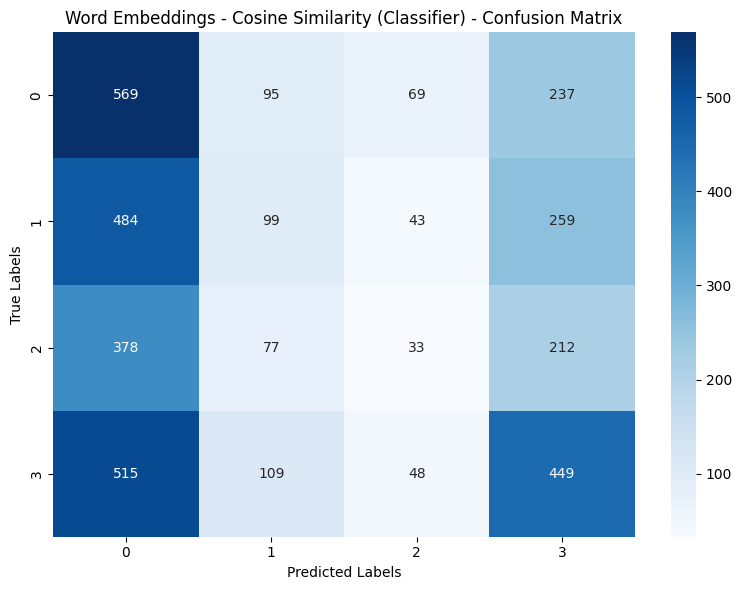

Results saved to: eval_results\word_cosine_classification.json


In [30]:
test_y_pred = predict_classification(test_X, model)
results = common_evaluation.evaluate_classification(test_y_true_classification, test_y_pred, description="Word Embeddings - Cosine Similarity (Classifier)", save_json_file_name="word_cosine_classification.json")



Regression Evaluation for Word Embeddings - Cosine Similarity (Regression)
Mean Squared Error (MSE): 2.750
Mean Absolute Error (MAE): 1.301
R2 Score: -1.005


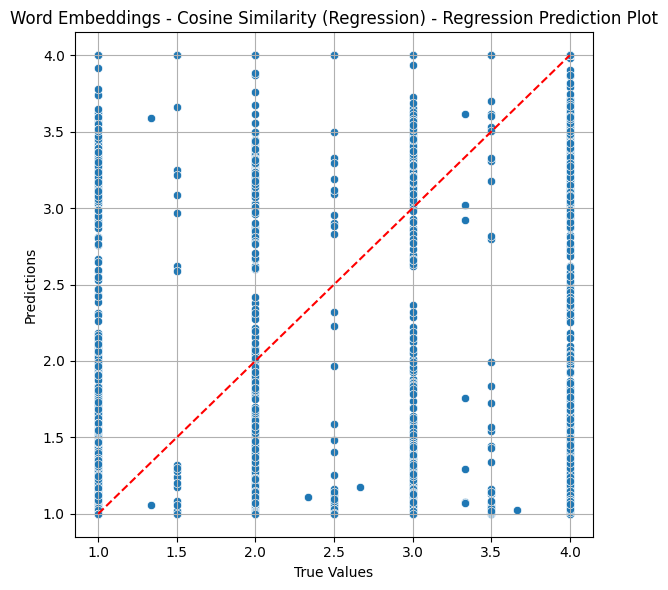

Results saved to: eval_results\word_cosine_regression.json


In [31]:
test_y_pred = predict_regression(test_X, model)
results = common_evaluation.evaluate_regression(test_y_true, test_y_pred, description="Word Embeddings - Cosine Similarity (Regression)", save_json_file_name="word_cosine_regression.json")

# Evaluate with Test Data (English only)

In [32]:
test_df = pd.read_csv("test_data/test_dataset.csv")

# Filter for English-only pairs
test_df = test_df[(test_df["lang1"] == "en") & (test_df["lang2"] == "en")].reset_index(drop=True)

test_y_true = test_df["overall"]
test_y_true_classification = test_df["overall_classification"]

test_X = test_df.drop(columns=[
    "overall",
    "overall_classification",
    "geography", "entities", "time", "narrative", "style", "tone"
])



Classification Evaluation for Word Embeddings - Cosine Similarity (Classifier) - English only
Accuracy: 0.304
Precision (weighted): 0.196
Recall (weighted): 0.304
F1 Score (weighted): 0.237

Classification Report:
              precision    recall  f1-score   support

           1      0.465     0.767     0.579        60
           2      0.122     0.167     0.141        36
           3      0.107     0.103     0.105        29
           4      0.000     0.000     0.000        56

    accuracy                          0.304       181
   macro avg      0.174     0.259     0.206       181
weighted avg      0.196     0.304     0.237       181



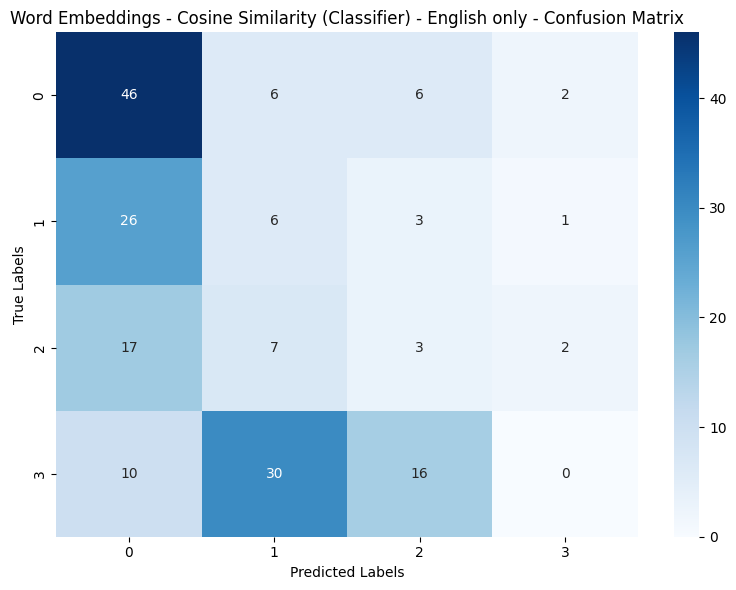

Results saved to: eval_results\word_cosine_classification_english.json


In [33]:
test_y_pred = predict_classification(test_X, model)
results = common_evaluation.evaluate_classification(test_y_true_classification, test_y_pred, description="Word Embeddings - Cosine Similarity (Classifier) - English only", save_json_file_name="word_cosine_classification_english.json")



Regression Evaluation for Word Embeddings - Cosine Similarity (Regression) - English only
Mean Squared Error (MSE): 2.396
Mean Absolute Error (MAE): 1.233
R2 Score: -0.612


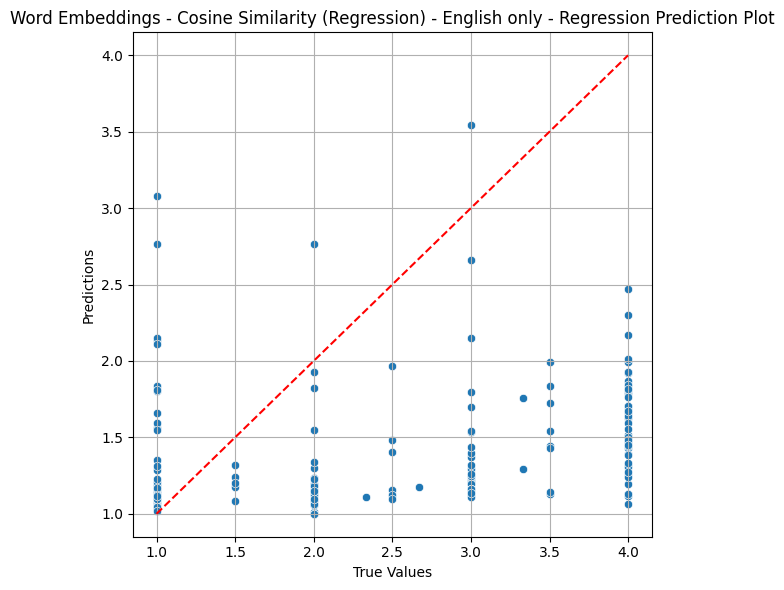

Results saved to: eval_results\word_cosine_regression_english.json


In [34]:
test_y_pred = predict_regression(test_X, model)
results = common_evaluation.evaluate_regression(test_y_true, test_y_pred, description="Word Embeddings - Cosine Similarity (Regression) - English only", save_json_file_name="word_cosine_regression_english.json")